<a href="https://colab.research.google.com/github/samer-glitch/Leveraging-Machine-Learning-for-Identifying-and-Classifying-Cyber-Threats-in-Network-Environments/blob/main/ReducedFeatures-100000instances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Unicauca-dataset-April-June-2019-Network-flows-100000rows(ALLFEATURES).csv to Unicauca-dataset-April-June-2019-Network-flows-100000rows(ALLFEATURES).csv


<ipython-input-6-5ab7003723f6>:39: DtypeWarning: Columns (0,2,4,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-100000rows(ALLFEATURES).csv')


Dataset Loaded and Preprocessed - Time Elapsed: 0:00:00.000082
Classifiers Fitted - Time Elapsed: 0:02:42.471490


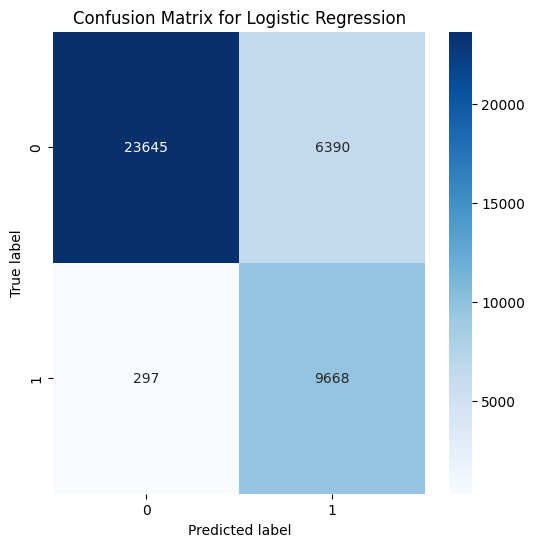

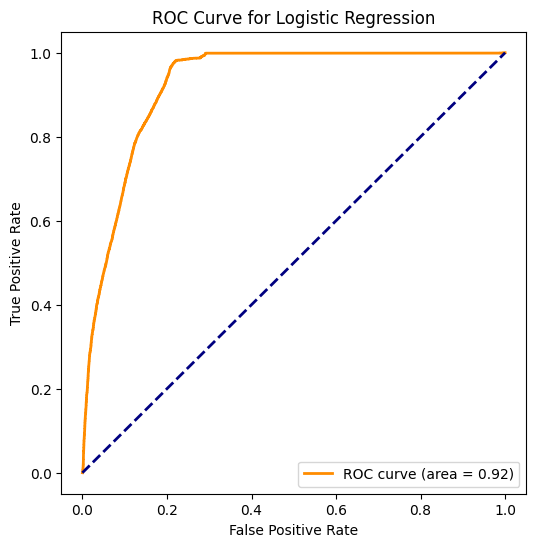

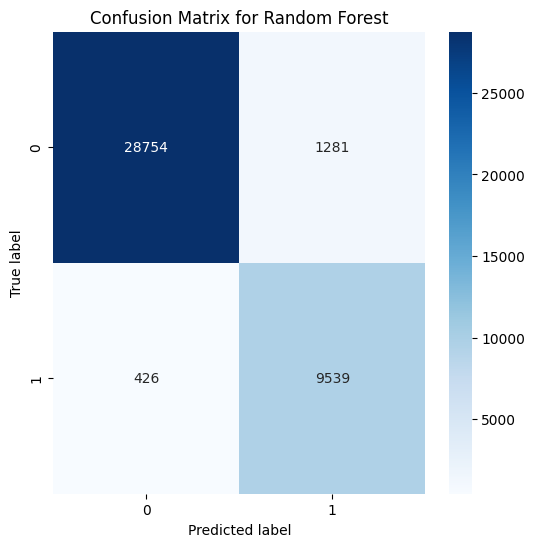

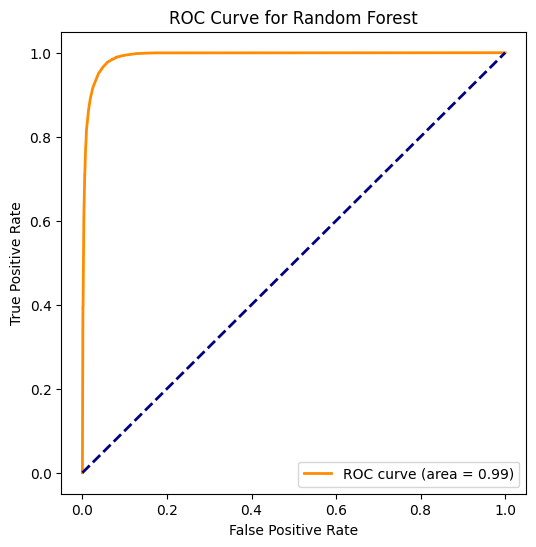

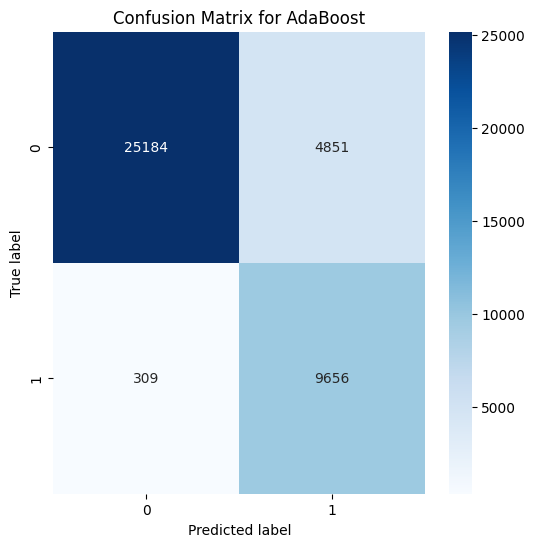

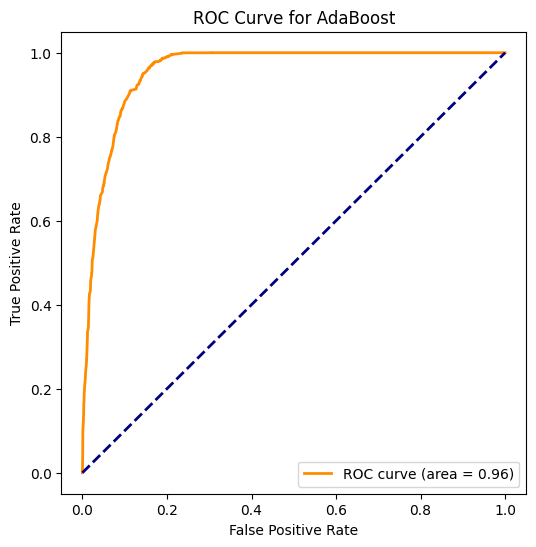

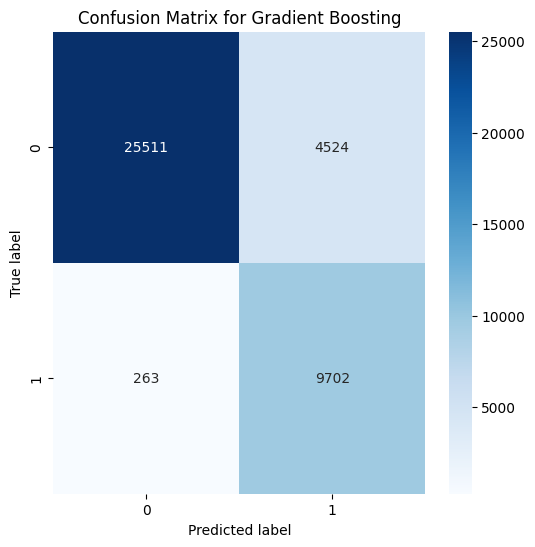

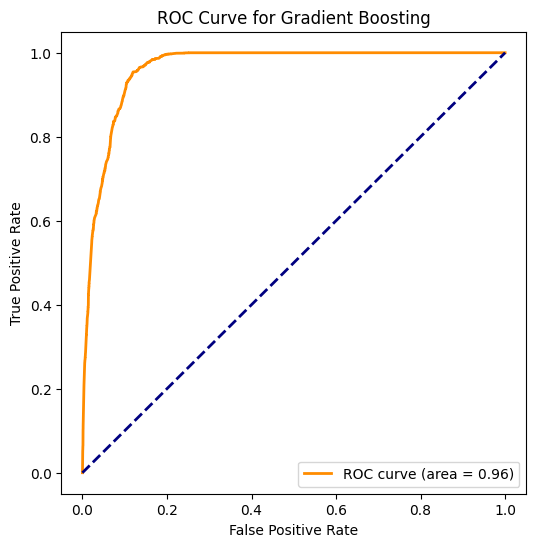

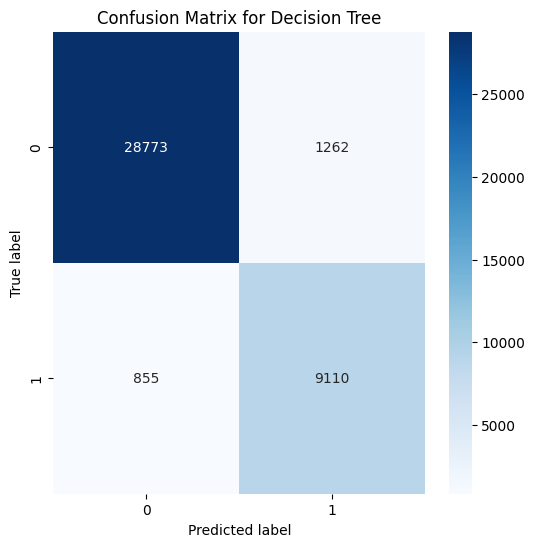

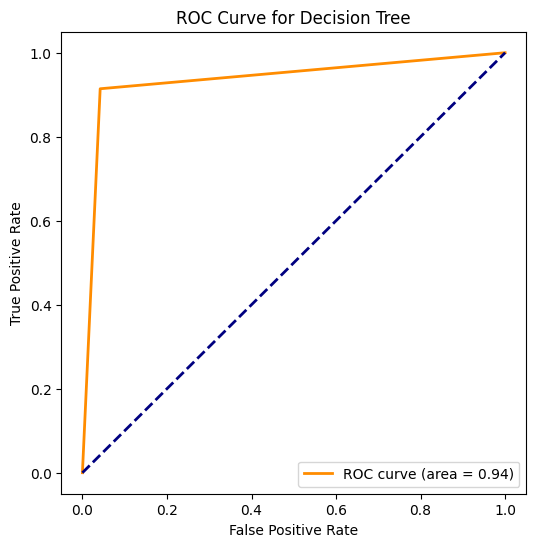


Logistic Regression Classifier:
Accuracy: 0.832825 
F1-Score: 0.7430350074933713

Random Forest Classifier:
Accuracy: 0.957325 
F1-Score: 0.9178734664421457

AdaBoost Classifier:
Accuracy: 0.871 
F1-Score: 0.7891467799934618

Gradient Boosting Classifier:
Accuracy: 0.880325 
F1-Score: 0.8021164896035715

Decision Tree Classifier:
Accuracy: 0.947075 
F1-Score: 0.8959040173083542
malicious    150176
normal        49824
Name: traffic_label, dtype: int64

Process Completed - Time: 0:02:47.985698


In [6]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

def record_time(step_name, overall_start_time):
    print(f"{step_name} - Time Elapsed: {datetime.datetime.now() - overall_start_time}")

def plot_confusion_matrix(cm, classifier_name):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {classifier_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_roc_curve(y_true, y_scores, classifier_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {classifier_name}')
    plt.legend(loc='lower right')
    plt.show()

# Load the dataset

df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-100000rows(ALLFEATURES).csv')

# Handle NaN values and mixed types
df = df.apply(lambda x: x.fillna(x.mean()) if x.dtype == np.float64 else x.fillna('Unknown'))

overall_start_time = datetime.datetime.now()
record_time("Dataset Loaded and Preprocessed", overall_start_time)

# Define a function to label traffic as normal or malicious
def label_traffic(df):
    # Define normal thresholds
    normal_protocols = [6, 17, 1]  # TCP and UDP
    normal_port_range = set(range(0, 49152))
    normal_pkt_count_max = 2000
    normal_octet_count_max = 1000000
    normal_packet_size_range = range(20, 1500)
    normal_flow_duration_range = range(50, 3600000)  # 50 ms to 1 hour
    normal_piat_range = range(0, 10000)  # 0 to 10 seconds
    max_timestamp = int(1e12)  # Assuming timestamp in milliseconds

    # Initialize the traffic_label column
    df['traffic_label'] = 'normal'

    # Vectorized conditions
    df.loc[~df['proto'].isin(normal_protocols), 'traffic_label'] = 'malicious'
    df.loc[df['flowEndReason'] == 1, 'traffic_label'] = 'malicious'
    df.loc[~df['src_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[~df['dst_port'].isin(normal_port_range), 'traffic_label'] = 'malicious'
    df.loc[df['pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
    df.loc[df['octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
    df.loc[~df['min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
    df.loc[~df['flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
    df.loc[~df['min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[~df['std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
    df.loc[(df['flowStart'] < 0) | (df['flowStart'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[(df['flowEnd'] < 0) | (df['flowEnd'] > max_timestamp), 'traffic_label'] = 'malicious'
    df.loc[df['flowEnd'] < df['flowStart'], 'traffic_label'] = 'malicious'

    # Process forward and backward flow features
    for prefix in ['f_', 'b_']:
        df.loc[df[prefix + 'pktTotalCount'] > normal_pkt_count_max, 'traffic_label'] = 'malicious'
        df.loc[df[prefix + 'octetTotalCount'] > normal_octet_count_max, 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_ps'].isin(normal_packet_size_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'flowDuration'].isin(normal_flow_duration_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'min_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'max_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'avg_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'
        df.loc[~df[prefix + 'std_dev_piat'].isin(normal_piat_range), 'traffic_label'] = 'malicious'

        # Convert IP columns to string, handling NaN values
        df['src_ip'] = df['src_ip'].fillna('unknown').astype(str)
        df['dst_ip'] = df['dst_ip'].fillna('unknown').astype(str)

        # IP Address checks
        normal_src_ip_ranges = ['192.168.', '10.', '172.']
        df.loc[df['src_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'
        df.loc[df['dst_ip'].apply(lambda ip: any(ip.startswith(range) for range in normal_src_ip_ranges)), 'traffic_label'] = 'normal'


    # Web service, application protocol, and category checks
    normal_web_services = ['Google', 'Microsoft', 'HTTP', 'DNS', 'Amazon', 'MSN', 'TLS', 'Yahoo', 'DHCP', 'WindowsUpdate', 'NetBIOS', 'RX', 'MS_OneDrive', 'GMail', 'Dropbox', 'GoogleServices', 'ICMP', 'UbuntuONE', 'GoogleDrive', 'YouTube', 'HTTP_Proxy', 'NTP', 'Apple', 'AppleiTunes', 'AppleStore', 'ApplePush', 'AppleiCloud', 'IMAPS', 'IMO', 'Office365', 'Skype', 'Cloudflare']
    normal_application_protocols = ['HTTP', 'TLS', 'DNS', 'QUIC', 'IMAPS', 'STUN', 'SMTPS', 'POPS', 'Skype', 'SMBv23', 'NetBIOS', 'RDP', 'ApplePush', 'MQTT']
    normal_categories = ['Network', 'Web', 'SoftwareUpdate', 'RPC', 'System', 'Cloud', 'Mail', 'FTP', 'VPN', 'RemoteAccess', 'Email', 'Media', 'Streaming', 'VoIP', 'Collaborative']

    df.loc[~df['web_service'].isin(normal_web_services), 'traffic_label'] = 'malicious'
    df.loc[~df['application_protocol'].isin(normal_application_protocols), 'traffic_label'] = 'malicious'
    df.loc[~df['category'].isin(normal_categories), 'traffic_label'] = 'malicious'

    return df

df = label_traffic(df)

# Encode categorical labels
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['traffic_label'])

df.drop(['flow_key', 'src_ip_numeric', 'min_ps', 'max_ps', 'f_flowStart', 'f_flowEnd', 'f_flowDuration', 'f_min_piat'] + [col for col in df if col.startswith('b_')], axis=1, inplace=True)

# Drop non-numeric columns before defining features (X) and target variable (y)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
X = df[numeric_cols].drop(columns=['category_encoded'])
y = df['category_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply scaling to numeric data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE to address class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


# Define the StratifiedKFold cross-validator
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Hyperparameter grids
param_grid_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
}
param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
}
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
}
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}



# GridSearchCV for each classifier
rf_clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid_rf, cv=stratified_kfold)
ab_clf = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid=param_grid_ab, cv=stratified_kfold)
gb_clf = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid=param_grid_gb, cv=stratified_kfold)
dt_clf = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_grid_dt, cv=stratified_kfold)

# Define and fit the classifiers (After GridSearchCV)
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
ab_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=50, random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)

lr_clf.fit(X_train_resampled, y_train_resampled)
rf_clf.fit(X_train_resampled, y_train_resampled)
ab_clf.fit(X_train_resampled, y_train_resampled)
gb_clf.fit(X_train_resampled, y_train_resampled)
dt_clf.fit(X_train_resampled, y_train_resampled)
record_time("Classifiers Fitted", overall_start_time)

# Evaluate models and plot confusion matrices and ROC curves
for clf, name in [(lr_clf, 'Logistic Regression'), (rf_clf, 'Random Forest'), (ab_clf, 'AdaBoost'), (gb_clf, 'Gradient Boosting'), (dt_clf, 'Decision Tree')]:
    # Predictions and probabilities
    y_pred = clf.predict(X_test_scaled)
    y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, name)

    # ROC curve
    plot_roc_curve(y_test, y_pred_proba, name)

# Calculate accuracy and F1-score for each model
lr_accuracy, lr_f1 = accuracy_score(y_test, lr_clf.predict(X_test_scaled)), f1_score(y_test, lr_clf.predict(X_test_scaled))
rf_accuracy, rf_f1 = accuracy_score(y_test, rf_clf.predict(X_test_scaled)), f1_score(y_test, rf_clf.predict(X_test_scaled))
ab_accuracy, ab_f1 = accuracy_score(y_test, ab_clf.predict(X_test_scaled)), f1_score(y_test, ab_clf.predict(X_test_scaled))
gb_accuracy, gb_f1 = accuracy_score(y_test, gb_clf.predict(X_test_scaled)), f1_score(y_test, gb_clf.predict(X_test_scaled))
dt_accuracy, dt_f1 = accuracy_score(y_test, dt_clf.predict(X_test_scaled)), f1_score(y_test, dt_clf.predict(X_test_scaled))

# Print the results
print("\nLogistic Regression Classifier:\nAccuracy:", lr_accuracy, "\nF1-Score:", lr_f1)
print("\nRandom Forest Classifier:\nAccuracy:", rf_accuracy, "\nF1-Score:", rf_f1)
print("\nAdaBoost Classifier:\nAccuracy:", ab_accuracy, "\nF1-Score:", ab_f1)
print("\nGradient Boosting Classifier:\nAccuracy:", gb_accuracy, "\nF1-Score:", gb_f1)
print("\nDecision Tree Classifier:\nAccuracy:", dt_accuracy, "\nF1-Score:", dt_f1)
class_counts = df['traffic_label'].value_counts()
print(class_counts)
print("\nProcess Completed - Time:", datetime.datetime.now() - overall_start_time)